In [1]:
from LegoRL import *

In [2]:
import gym
env = gym.make('CartPole-v0').unwrapped

In [3]:
import torch.nn as nn
CartpoleNN = lambda: nn.Sequential(
                nn.Linear(4, 20),
                nn.ReLU(),
                nn.Linear(20, 20),
                nn.ReLU()
)

# DQN (without Target network)

In [4]:
agent = Composed(
    visualizer = Visualizer(),
    runner     = Runner(policy="policy"),
    replay     = ReplayBuffer(runner="runner"),
    sampler    = Sampler(replay="replay"),
    backbone   = Backbone(CartpoleNN()),
    q_head     = QualityHead(backbone="backbone"),
    loss       = OptimalCriticLoss(sampler="sampler", critic="q_head"),
    trainer    = Trainer(backbone="backbone", losses=["loss"]),
    policy     = eGreedy(greedy_policy="q_head"),
)

In [5]:
system = System(agent, env)

Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


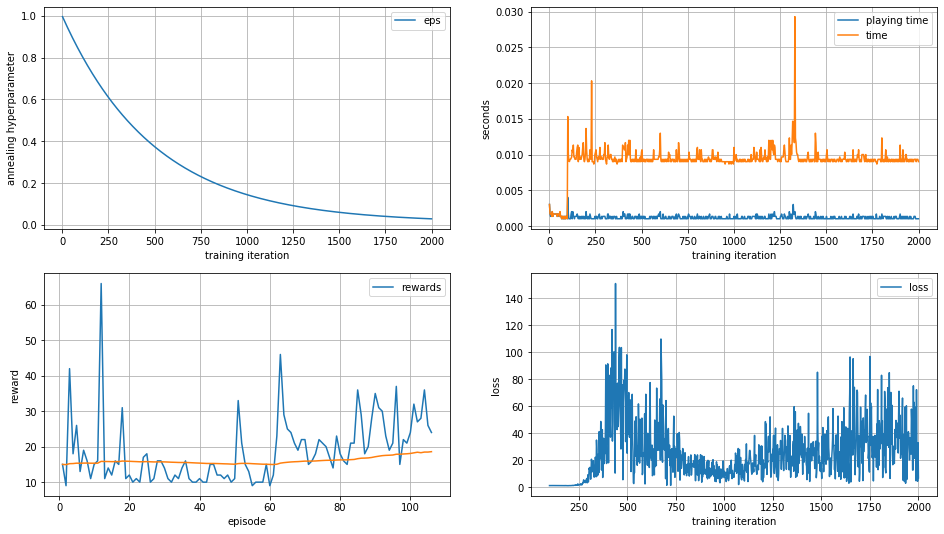

In [6]:
system.run(2000)

# DQN

In [7]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy"),
    replay          = ReplayBuffer(runner="runner"),
    sampler         = Sampler(replay="replay"),
    backbone        = Backbone(CartpoleNN()),
    q_head          = QualityHead(backbone="backbone"),
    loss            = OptimalCriticLoss(sampler="sampler", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_head     = Frozen(QualityHead)(backbone="frozen_backbone", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
    policy          = eGreedy(greedy_policy="q_head"),
)

In [8]:
system = System(agent, env)

Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


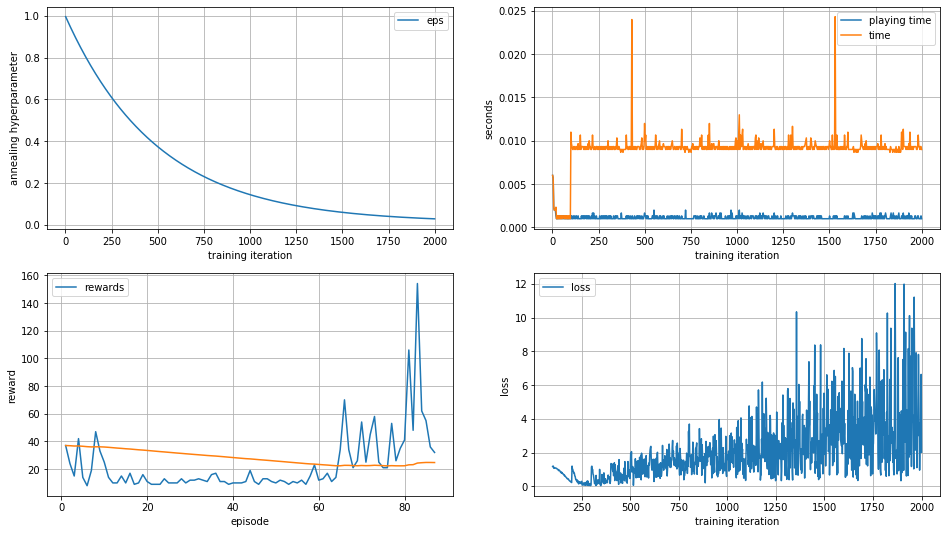

In [9]:
system.run(2000)

# Double DQN

In [10]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy"),
    replay          = ReplayBuffer(runner="runner"),
    sampler         = Sampler(replay="replay"),
    backbone        = Backbone(CartpoleNN()),
    q_head          = QualityHead(backbone="backbone"),
    loss            = DoubleCriticLoss(sampler="sampler", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_head     = Frozen(QualityHead)(backbone="frozen_backbone", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
    policy          = eGreedy(greedy_policy="q_head"),
)

In [11]:
system = System(agent, env)

Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


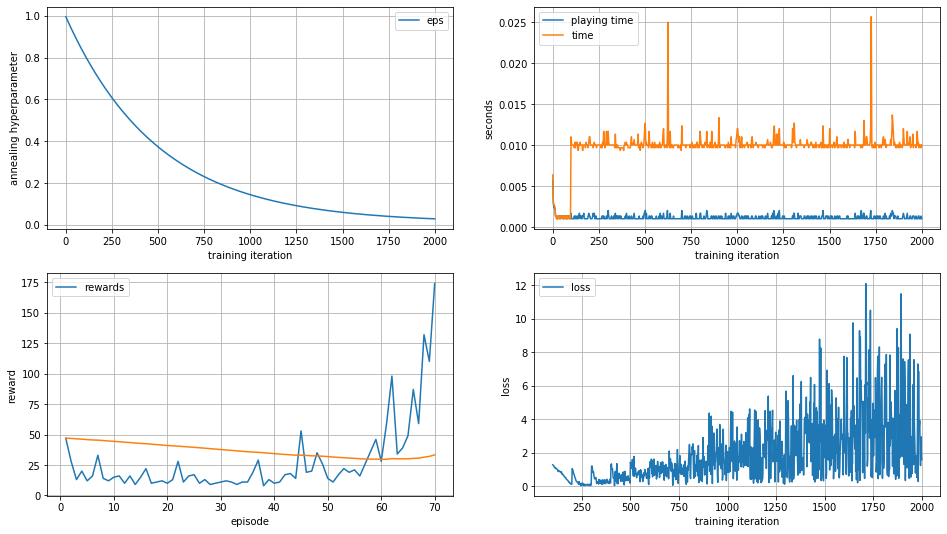

In [12]:
system.run(2000)

# Dueling Double DQN

In [13]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy"),
    replay          = ReplayBuffer(runner="runner"),
    sampler         = Sampler(replay="replay"),
    backbone        = Backbone(CartpoleNN()),
    v_head          = ValueHead(backbone="backbone"),
    q_head          = Dueling(backbone="backbone", value_head="v_head"),
    loss            = DoubleCriticLoss(sampler="sampler", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_v_head   = Frozen(ValueHead)(backbone="frozen_backbone", source="v_head"),
    frozen_head     = Frozen(Dueling)(backbone="frozen_backbone", value_head="frozen_v_head", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
    policy          = eGreedy(greedy_policy="q_head"),
)

In [14]:
system = System(agent, env)

Adding new head <v_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([])
Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


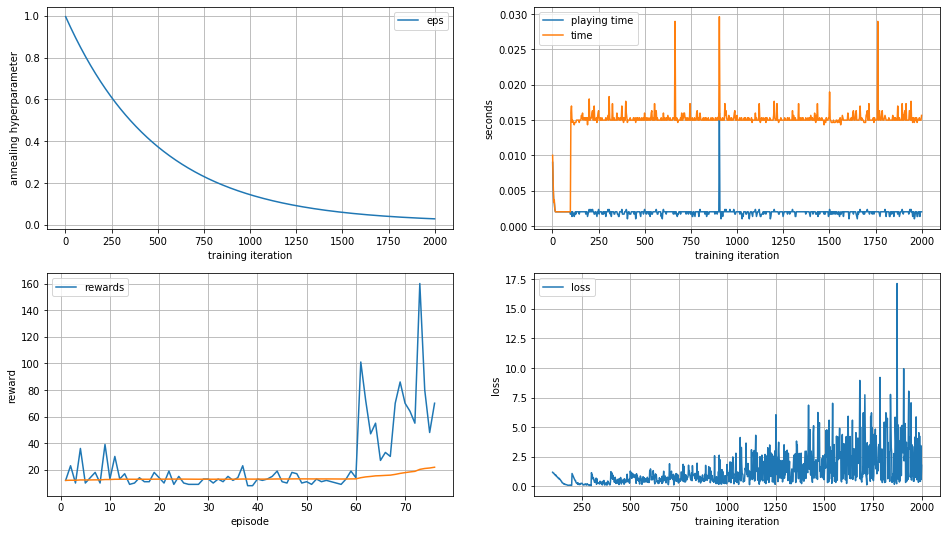

In [15]:
system.run(2000)

# Dueling Double DQN with PrioritizedReplay

In [16]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy"),
    replay          = ReplayBuffer(runner="runner"),
    sampler         = PrioritizedSampler(replay="replay"),
    corrected       = SamplerBiasCorrection(sampler="sampler"),
    updater         = PrioritiesUpdater(sampler="sampler", priority_provider="loss"),
    backbone        = Backbone(CartpoleNN()),
    v_head          = ValueHead(backbone="backbone"),
    q_head          = Dueling(backbone="backbone", value_head="v_head"),
    loss            = DoubleCriticLoss(sampler="corrected", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_v_head   = Frozen(ValueHead)(backbone="frozen_backbone", source="v_head"),
    frozen_head     = Frozen(Dueling)(backbone="frozen_backbone", value_head="frozen_v_head", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
    policy          = eGreedy(greedy_policy="q_head"),
)

In [17]:
system = System(agent, env)

Adding new head <v_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([])
Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


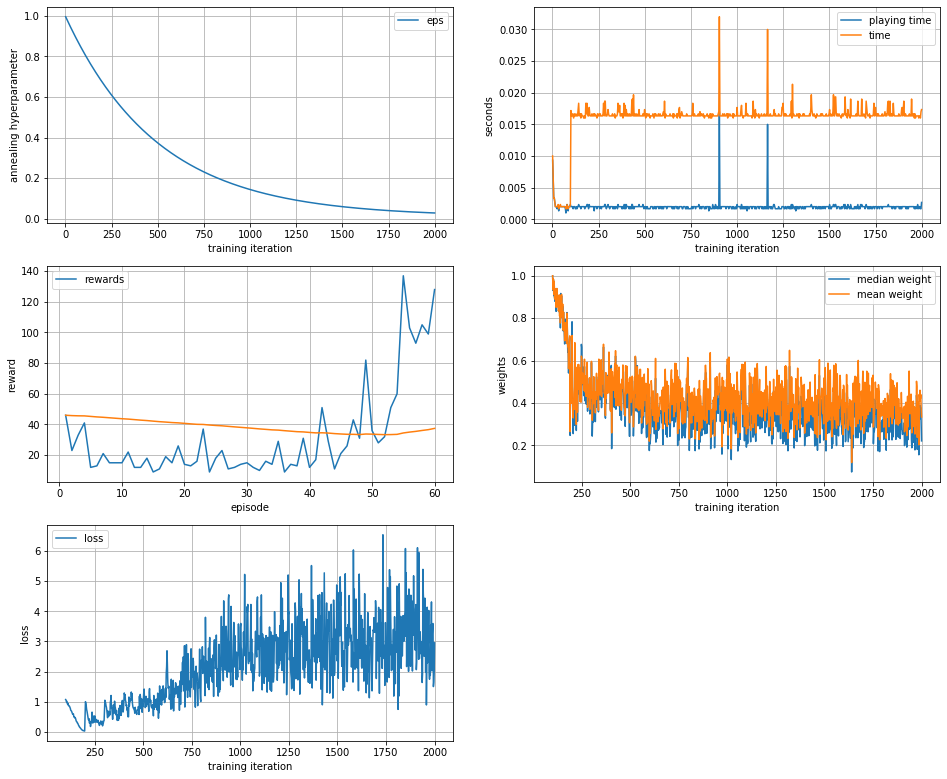

In [18]:
system.run(2000)

# N-step Dueling Double DQN with PrioritizedReplay

In [19]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy"),
    latency         = NstepLatency(runner="runner"),
    replay          = ReplayBuffer(runner="latency"),
    sampler         = PrioritizedSampler(replay="replay"),
    corrected       = SamplerBiasCorrection(sampler="sampler"),
    updater         = PrioritiesUpdater(sampler="sampler", priority_provider="loss"),
    backbone        = Backbone(CartpoleNN()),
    v_head          = ValueHead(backbone="backbone"),
    q_head          = Dueling(backbone="backbone", value_head="v_head"),
    loss            = DoubleCriticLoss(sampler="corrected", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_v_head   = Frozen(ValueHead)(backbone="frozen_backbone", source="v_head"),
    frozen_head     = Frozen(Dueling)(backbone="frozen_backbone", value_head="frozen_v_head", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
    policy          = eGreedy(greedy_policy="q_head"),
)

In [20]:
system = System(agent, env)

Adding new head <v_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([])
Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


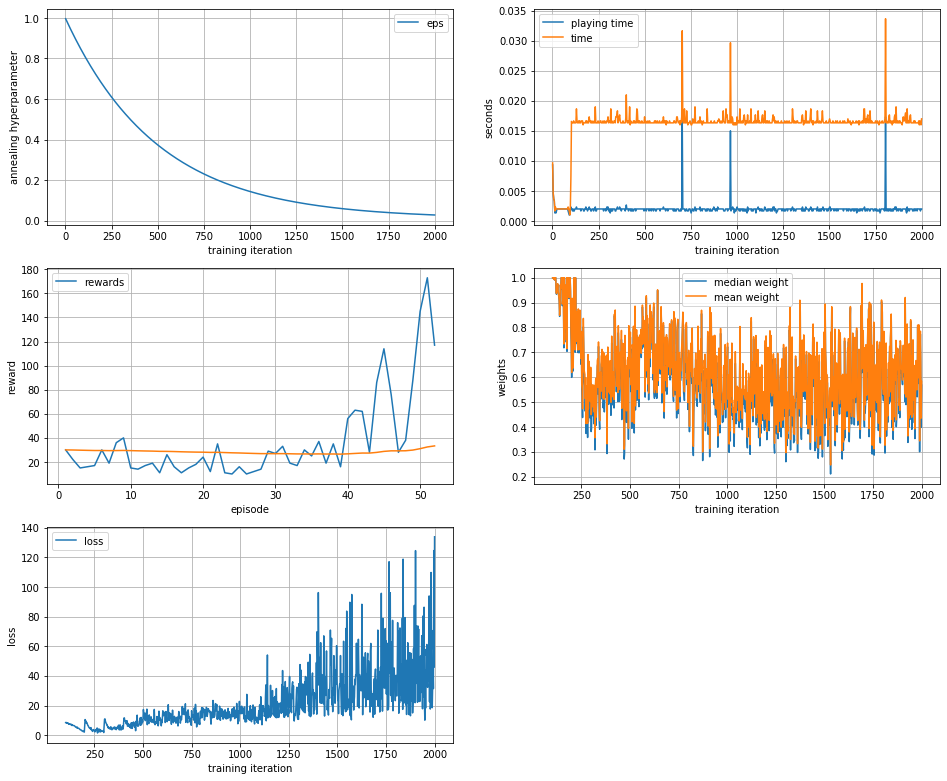

In [21]:
system.run(2000)

# Noisy N-step Dueling Double DQN with PrioritizedReplay

In [22]:
NoisyCartpoleNN = lambda: nn.Sequential(
                NoisyLinear()(4, 20),
                nn.ReLU(),
                NoisyLinear()(20, 20),
                nn.ReLU()
)

In [23]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="q_head"),
    latency         = NstepLatency(runner="runner"),
    replay          = ReplayBuffer(runner="latency"),
    sampler         = PrioritizedSampler(replay="replay"),
    corrected       = SamplerBiasCorrection(sampler="sampler"),
    updater         = PrioritiesUpdater(sampler="sampler", priority_provider="loss"),
    backbone        = Backbone(NoisyCartpoleNN()),
    v_head          = ValueHead(backbone="backbone", network=NoisyLinear()),
    q_head          = Dueling(backbone="backbone", network=NoisyLinear(), value_head="v_head"),
    loss            = DoubleCriticLoss(sampler="corrected", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_v_head   = Frozen(ValueHead)(backbone="frozen_backbone", source="v_head"),
    frozen_head     = Frozen(Dueling)(backbone="frozen_backbone", value_head="frozen_v_head", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
)

In [24]:
system = System(agent, env)

Adding new head <v_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([])
Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([2])


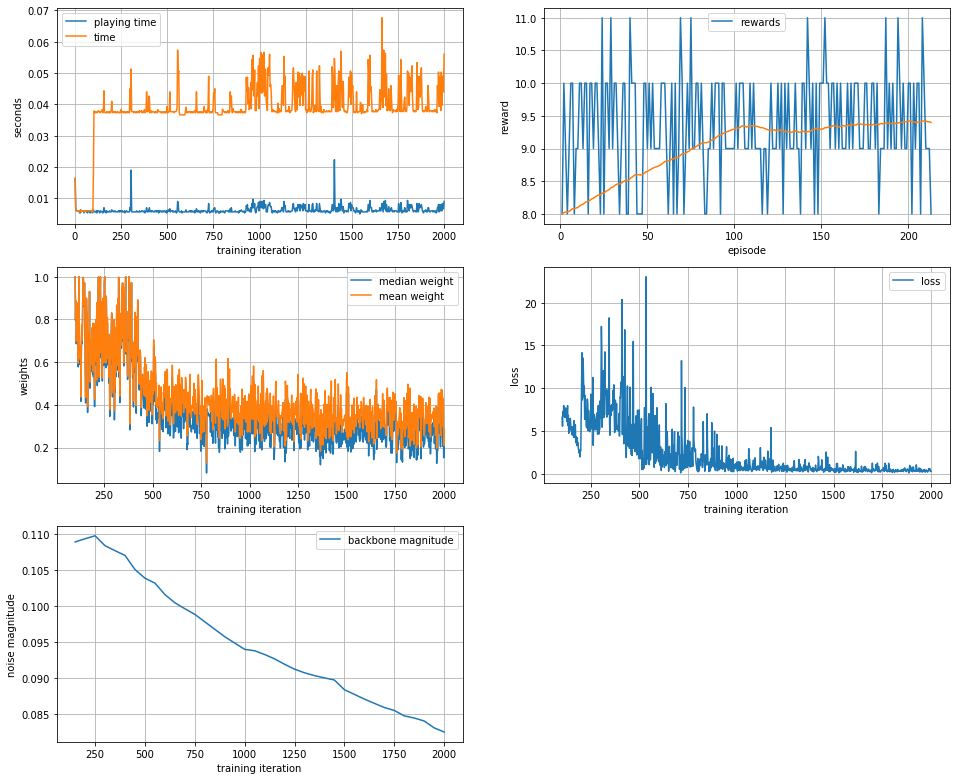

In [25]:
system.run(2000)

# Categorical DQN (also known as c51)

In [26]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="policy"),
    replay          = ReplayBuffer(runner="runner"),
    sampler         = Sampler(replay="replay"),
    backbone        = Backbone(CartpoleNN()),
    q_head          = QualityHead(backbone="backbone", representation=Categorical(-10, 10, 51)(Q(V))),
    loss            = OptimalCriticLoss(sampler="sampler", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_head     = Frozen(QualityHead)(backbone="frozen_backbone", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
    policy          = eGreedy(greedy_policy="q_head"),
)

In [27]:
system = System(agent, env)

Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([51, 2])


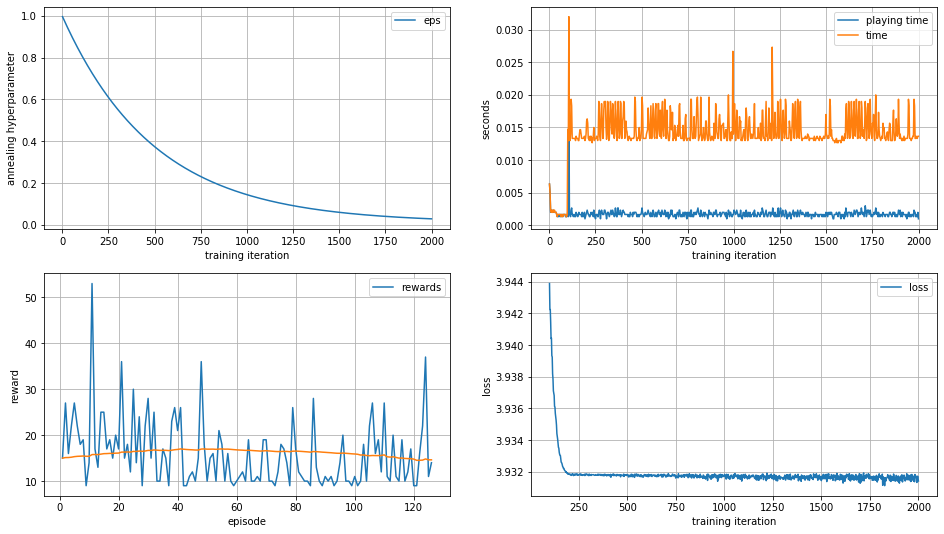

In [28]:
system.run(2000)

# Rainbow DQN

In [29]:
agent = Composed(
    visualizer      = Visualizer(),
    runner          = Runner(policy="q_head"),
    latency         = NstepLatency(runner="runner"),
    replay          = ReplayBuffer(runner="latency"),
    sampler         = PrioritizedSampler(replay="replay"),
    corrected       = SamplerBiasCorrection(sampler="sampler"),
    updater         = PrioritiesUpdater(sampler="sampler", priority_provider="loss"),
    backbone        = Backbone(NoisyCartpoleNN()),
    v_head          = ValueHead(backbone="backbone", network=NoisyLinear(), representation=Categorical(-10, 10, 51)(V)),
    q_head          = Dueling(backbone="backbone", network=NoisyLinear(), value_head="v_head", representation=Categorical(-10, 10, 51)(Q(V))),
    loss            = DoubleCriticLoss(sampler="corrected", critic="q_head", target_critic="frozen_head"),
    frozen_backbone = Frozen(Backbone)(source="backbone"),
    frozen_v_head   = Frozen(ValueHead)(backbone="frozen_backbone", source="v_head"),
    frozen_head     = Frozen(Dueling)(backbone="frozen_backbone", value_head="frozen_v_head", source="q_head"),
    trainer         = Trainer(backbone="backbone", losses=["loss"]),
)

In [30]:
system = System(agent, env)

Adding new head <v_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([51])
Adding new head <q_head> to <backbone>:
  Input shape is (4,)
  Backbone feature size is 20
  Desired output is torch.Size([51, 2])


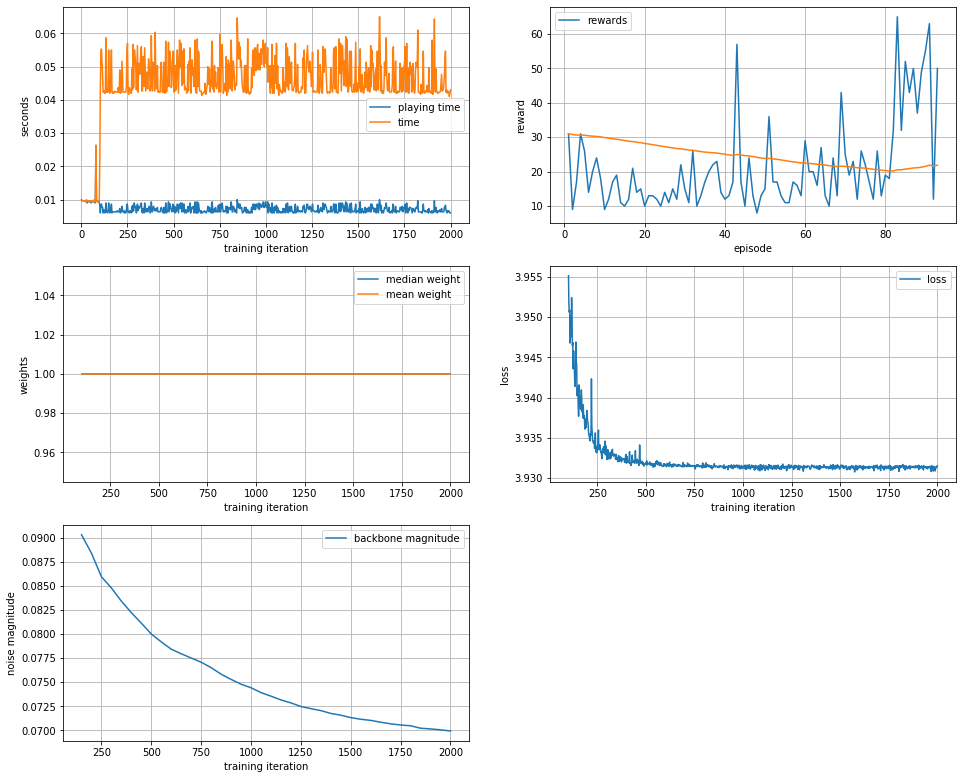

In [31]:
system.run(2000)

### All modules description:

In [32]:
agent

<visualizer>: Plots logs every 100 iteration
<runner>: Makes one step in parallel environments each 1 iteration using <q_head>
<latency>: Substitutes stream from <runner> to 3-step transitions
<replay>: Stores observations from <latency>
<sampler>: Each 1 iteration samples mini-batch from <replay> using priorities
<corrected>: Adds weights to mini-batches from <sampler> to correct bias
<updater>: Each 1 iteration updates priorities of <sampler> using priorities from <loss>
<backbone>: Backbone of network
<v_head>: Head, connected to <backbone>, modeling CategoricalValue
<q_head>: Head, connected to <backbone>, modeling CategoricalValue in dueling form (V + A - A.mean())
<loss>: Calculates Double DQN loss for <q_head> using <frozen_head> as estimator and data from <corrected>
<frozen_backbone>: Copy of <backbone>, updated each 100 iteration
<frozen_v_head>: Copy of <v_head>, updated each 100 iteration
<frozen_head>: Copy of <q_head>, updated each 100 iteration
<trainer>: Trains <backbon